Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

image 1/1 /content/6.jpg: 448x640 1 License_Plate, 150.4ms
Speed: 4.2ms preprocess, 150.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


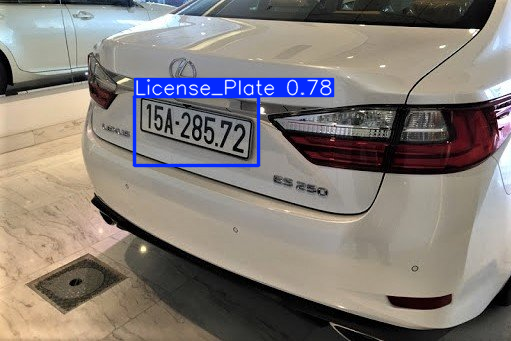

tensor([[134.2127,  96.2302, 258.8195, 165.8500]])


In [ ]:
!pip install -U --quiet ultralytics

from google.colab import drive
drive.mount('/content/drive')

from ultralytics import YOLO
import os

model = YOLO("/content/drive/MyDrive/Training_AI/runs/detect/train7/weights/best.pt")

image_path = "/content/6.jpg"
results = model(image_path)

results[0].show()
print(results[0].boxes.xyxy)


image 1/1 /content/3.jpg: 384x640 1 License_Plate, 119.9ms
Speed: 2.8ms preprocess, 119.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

>>> BIỂN SỐ PHÁT HIỆN: 37A55555


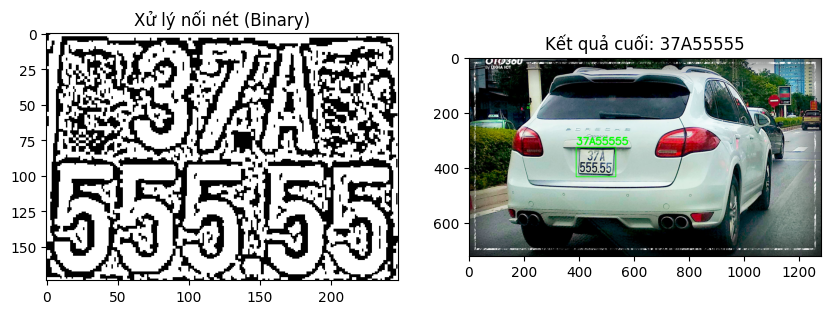

In [ ]:
import cv2
import numpy as np
import easyocr
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# ==========================================
# 1. KHỞI TẠO & CẤU HÌNH
# ==========================================
# Thay đổi đường dẫn model và ảnh của bạn tại đây
MODEL_PATH = "/content/drive/MyDrive/Training_AI/runs/detect/train7/weights/best.pt"
IMAGE_PATH = "/content/3.jpg"

# Khởi tạo EasyOCR (Sử dụng CPU)
reader = easyocr.Reader(['en'], gpu=False)

# Từ điển sửa lỗi: Ưu tiên các lỗi nhận diện phổ biến
dict_char_to_int = {
    'O': '0', 'D': '0', 'Q': '0', 'U': '0', 'C': '0',
    'I': '1', 'L': '1', 'T': '1',
    'Z': '2',
    'J': '3',
    'A': '4',
    'S': '5', 'F': '5',
    'G': '6', 'E': '6', 'b': '6', 'R': '6',
    'B': '8', 'H': '8', 'K': '8',
    'q': '9', 'P': '9', 'g': '9'
}

dict_int_to_char = {
    '0': 'O', '1': 'I', '2': 'Z', '3': 'J',
    '4': 'A', '6': 'G', '5': 'S', '8': 'B'
}

# ==========================================
# 2. HÀM XỬ LÝ ẢNH (NẮN THẲNG & TIỀN XỬ LÝ)
# ==========================================

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    wA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    wB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(wA), int(wB))
    hA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    hB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(hA), int(hB))
    dst = np.array([[0, 0], [maxWidth-1, 0], [maxWidth-1, maxHeight-1], [0, maxHeight-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(image, M, (maxWidth, maxHeight))

def align_plate(img_crop):
    gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 200)
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            return four_point_transform(img_crop, approx.reshape(4, 2))
    return img_crop

def preprocess_for_ocr(img):
    """Tiền xử lý nâng cao để nối nét chữ A và làm rõ số 6, 9"""
    img = cv2.resize(img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Làm nét cạnh
    kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    gray_sharp = cv2.filter2D(gray, -1, kernel_sharpen)

    # Tăng tương phản cục bộ
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray_enhanced = clahe.apply(gray_sharp)

    # Nhị phân hóa
    thresh = cv2.adaptiveThreshold(gray_enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 25, 11)

    # --- PHÉP TOÁN QUAN TRỌNG: MORPH_CLOSE ---
    # Dùng để điền đầy khoảng trống nhỏ, giúp nối lại gạch ngang của chữ A
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 3))
    thresh_closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel_close)

    # Làm đậm nét để nối các nét đứt còn sót lại
    kernel_dilate = np.ones((2, 2), np.uint8)
    thresh_final = cv2.dilate(thresh_closed, kernel_dilate, iterations=1)

    return gray_enhanced, thresh_final

# ==========================================
# 3. ĐỌC VÀ ÉP ĐỊNH DẠNG BIỂN SỐ
# ==========================================

def robust_read(image_list):
    best_text = ""
    best_conf = 0
    safe_chars = '0123456789ABCDEFGHKLMNPSTXYZEFb.-'

    for img in image_list:
        res = reader.readtext(img, allowlist=safe_chars, detail=1)
        full_text = "".join([item[1] for item in res if item[2] > 0.15])
        avg_conf = sum([item[2] for item in res]) / len(res) if res else 0

        if len(full_text) > len(best_text):
            best_text = full_text
            best_conf = avg_conf
        elif len(full_text) == len(best_text) and avg_conf > best_conf:
            best_text = full_text
            best_conf = avg_conf

    return best_text

def post_process_ocr(text):
    """Ép định dạng: 2 số - 1 chữ - 5 số (Strict format)"""
    clean_text = text.upper().replace(' ', '').replace('.', '').replace('-', '').replace('_', '')
    list_char = list(clean_text)

    if len(list_char) >= 7:
        # Vùng 1: Hai ký tự đầu PHẢI là SỐ (Mã tỉnh)
        list_char[0] = dict_char_to_int.get(list_char[0], list_char[0])
        list_char[1] = dict_char_to_int.get(list_char[1], list_char[1])

        # Vùng 2: Ký tự thứ 3 PHẢI là CHỮ (Series)
        if list_char[2] in dict_int_to_char:
             list_char[2] = dict_int_to_char[list_char[2]]

        # SỬA LỖI ĐẶC BIỆT: Nếu máy đọc nhầm A thành I, ép lại thành A vì A phổ biến hơn
        if list_char[2] == 'I' or list_char[2] == '1':
            list_char[2] = 'A'

        # Vùng 3: Các ký tự còn lại PHẢI là SỐ
        for i in range(3, len(list_char)):
            char = list_char[i]
            if char in dict_char_to_int:
                list_char[i] = dict_char_to_int[char]

    return "".join(list_char)

# ==========================================
# 4. CHƯƠNG TRÌNH CHÍNH
# ==========================================

def main():
    if not os.path.exists(MODEL_PATH):
        print("Lỗi: Không tìm thấy model!")
        return

    model = YOLO(MODEL_PATH)
    original_img = cv2.imread(IMAGE_PATH)
    results = model(IMAGE_PATH)

    for result in results:
        for box in result.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = box

            # Crop kèm padding để tìm cạnh tốt hơn
            pad = 15
            h_orig, w_orig = original_img.shape[:2]
            crop = original_img[max(0,int(y1)-pad):min(h_orig,int(y2)+pad),
                                max(0,int(x1)-pad):min(w_orig,int(x2)+pad)]

            # Bước 1: Nắn thẳng biển số
            aligned = align_plate(crop)

            # Bước 2: Tiền xử lý nối nét
            gray_ver, binary_ver = preprocess_for_ocr(aligned)

            # Bước 3: Xác định loại biển và OCR
            h, w = aligned.shape[:2]
            ratio = h / w
            final_raw_text = ""

            if ratio > 0.5: # Biển vuông
                split_h = int(gray_ver.shape[0] * 0.5)
                text_top = robust_read([gray_ver[0:split_h, :], binary_ver[0:split_h, :]])
                text_bot = robust_read([gray_ver[split_h:, :], binary_ver[split_h:, :]])
                final_raw_text = text_top + text_bot
            else: # Biển dài
                # Chỉ cắt 2% lề trái để loại bỏ viền đen/logo nhưng không cắt mất số
                m_left = int(gray_ver.shape[1] * 0.02)
                final_raw_text = robust_read([gray_ver[:, m_left:], binary_ver[:, m_left:]])

            # Bước 4: Hậu xử lý ép định dạng cứng
            final_res = post_process_ocr(final_raw_text)
            print(f"\n>>> BIỂN SỐ PHÁT HIỆN: {final_res}")

            # Hiển thị minh họa
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1); plt.imshow(binary_ver, cmap='gray'); plt.title("Xử lý nối nét (Binary)")
            plt.subplot(1, 2, 2)
            cv2.rectangle(original_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(original_img, final_res, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
            plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
            plt.title(f"Kết quả cuối: {final_res}")
            plt.show()

if __name__ == "__main__":
    main()